In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.linear_model import RidgeCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB 
from scipy import sparse
from IPython.display import display, HTML
from pprint import pprint
from keras.preprocessing.text import text_to_word_sequence
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import re 
import scipy
import pandas as pd
import numpy as np
import gc 
import pandas as pd
import numpy as np
import copy
import re
import string
import scipy.optimize as optimize
import re
import string
import copy
import nltk
import warnings
warnings.filterwarnings("ignore")
stop = stopwords.words('english')

pd.options.display.max_colwidth=300

def timer(func):
    def wrapper(*args, **kws):
        st = time.time()
        res = func(*args, **kws)
        et = time.time()
        tt = (et-st)/60
        print(f'Time taken is {tt:.2f} mins')
        return res
    return wrapper

df_test = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")
df_test_l = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv").replace(-1,0)
df_test = pd.merge(df_test, df_test_l, how="left", on = "id")
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
df = pd.concat([df, df_test])

cat_mtpl = {'obscene': 0.16, 'toxic': 0.32, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_mtpl:
    df[category] = df[category] * cat_mtpl[category]

df['score'] = df.loc[:, 'toxic':'identity_hate'].sum(axis=1)
df['y'] = df['score']
df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})

max_ = max(df['y'])
min_ = min(df['y'])
df['y'] = (df['y'] - min_) / (max_ - min_)

del df_test

In [2]:
df['y'].value_counts()

0.000000    290267
0.056940      7376
0.199288      5732
0.085409      2612
0.466192      2340
0.170819      1754
0.733096       550
0.323843       407
0.028470       366
0.113879       365
0.352313       258
0.437722       254
0.142349       196
0.266904        95
1.000000        45
0.380783        36
0.590747        25
0.409253        21
0.619217        15
0.704626        10
0.295374         5
0.857651         5
0.704626         1
Name: y, dtype: int64

In [3]:
n_folds = 10

frac_1 = 0.8
frac_1_factor = 1.5

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(44935, 2)
0.000000    26961
0.056940     5867
0.199288     4597
0.085409     2095
0.466192     1890
0.170819     1411
0.733096      445
0.323843      309
0.028470      298
0.113879      291
0.352313      206
0.437722      202
0.142349      161
0.266904       75
1.000000       33
0.380783       26
0.590747       21
0.409253       16
0.619217       13
0.704626        9
0.295374        5
0.857651        3
0.704626        1
Name: y, dtype: int64
Fold: 1
(44935, 2)
0.000000    26961
0.056940     5887
0.199288     4577
0.085409     2088
0.466192     1856
0.170819     1407
0.733096      460
0.323843      341
0.028470      293
0.113879      291
0.352313      211
0.437722      201
0.142349      161
0.266904       73
1.000000       34
0.380783       24
0.590747       20
0.409253       18
0.619217       12
0.704626       10
0.857651        5
0.295374        4
0.704626        1
Name: y, dtype: int64
Fold: 2
(44935, 2)
0.000000    26961
0.056940     5877
0.199288     4578
0.085409     2102

In [4]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

class BaseTokenizer(object):
    def process_text(self, text):
        raise NotImplemented

    def process(self, texts):
        for text in texts:
            yield self.process_text(text)

def clean_data(df):
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
    
    return df

In [5]:
n_folds = 10

frac_1 = 0.8
frac_1_factor = 1.5

df = clean_data(df)

for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(44935, 2)
0.000000    26961
0.056940     5867
0.199288     4597
0.085409     2095
0.466192     1890
0.170819     1411
0.733096      445
0.323843      309
0.028470      298
0.113879      291
0.352313      206
0.437722      202
0.142349      161
0.266904       75
1.000000       33
0.380783       26
0.590747       21
0.409253       16
0.619217       13
0.704626        9
0.295374        5
0.857651        3
0.704626        1
Name: y, dtype: int64
(44935, 2)
0.000000    26961
0.056940     5887
0.199288     4577
0.085409     2088
0.466192     1856
0.170819     1407
0.733096      460
0.323843      341
0.028470      293
0.113879      291
0.352313      211
0.437722      201
0.142349      161
0.266904       73
1.000000       34
0.380783       24
0.590747       20
0.409253       18
0.619217       12
0.704626       10
0.857651        5
0.295374        4
0.704626        1
Name: y, dtype: int64
(44935, 2)
0.000000    26961
0.056940     5877
0.199288     4578
0.085409     2102
0.466192     1880
0.170

In [6]:
del df,tmp_df
gc.collect()

21

(5838, 5)


<AxesSubplot:>

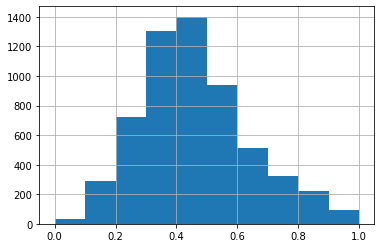

In [7]:
df_ = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text',
                                                                'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

In [8]:
n_folds = 10

frac_1 = 0.8

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4670, 2)
0.464668    136
0.475910    122
0.386510    104
0.408994    101
0.487152     99
           ... 
0.658458      1
0.238223      1
0.345289      1
0.942719      1
0.524625      1
Name: y, Length: 273, dtype: int64
Fold: 1
(4670, 2)
0.464668    127
0.475910    114
0.386510    108
0.408994    107
0.364561    103
           ... 
0.851713      1
0.859743      1
0.500000      1
0.051927      1
0.535332      1
Name: y, Length: 274, dtype: int64
Fold: 2
(4670, 2)
0.464668    133
0.475910    122
0.442719    110
0.386510    108
0.364561    102
           ... 
0.173448      1
0.906317      1
0.138651      1
0.918094      1
0.185225      1
Name: y, Length: 274, dtype: int64
Fold: 3
(4670, 2)
0.464668    132
0.475910    128
0.386510    106
0.408994    106
0.364561     99
           ... 
0.366167      1
0.103319      1
0.452355      1
0.594754      1
0.329764      1
Name: y, Length: 273, dtype: int64
Fold: 4
(4670, 2)
0.464668    144
0.475910    132
0.386510    116
0.442719    104
0.

In [9]:
n_folds = 10

frac_1 = 0.8

df_ = clean_data(df_)

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4670, 2)
0.464668    136
0.475910    122
0.386510    104
0.408994    101
0.487152     99
           ... 
0.658458      1
0.238223      1
0.345289      1
0.942719      1
0.524625      1
Name: y, Length: 273, dtype: int64
Fold: 1
(4670, 2)
0.464668    127
0.475910    114
0.386510    108
0.408994    107
0.364561    103
           ... 
0.851713      1
0.859743      1
0.500000      1
0.051927      1
0.535332      1
Name: y, Length: 274, dtype: int64
Fold: 2
(4670, 2)
0.464668    133
0.475910    122
0.442719    110
0.386510    108
0.364561    102
           ... 
0.173448      1
0.906317      1
0.138651      1
0.918094      1
0.185225      1
Name: y, Length: 274, dtype: int64
Fold: 3
(4670, 2)
0.464668    132
0.475910    128
0.386510    106
0.408994    106
0.364561     99
           ... 
0.366167      1
0.103319      1
0.452355      1
0.594754      1
0.329764      1
Name: y, Length: 273, dtype: int64
Fold: 4
(4670, 2)
0.464668    144
0.475910    132
0.386510    116
0.442719    104
0.

In [10]:
del tmp_df, df_; 
gc.collect()

67

In [11]:
df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")


class LengthTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self):
        return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self):
        return ["lngth_uppercase"]

0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

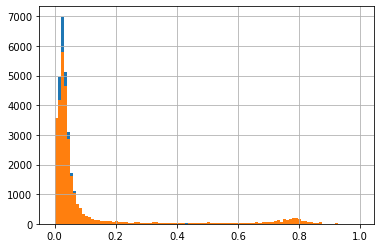

In [12]:

df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)

print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())

df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

In [13]:
df_val['upper_1'].head()

0    0.026316
1    0.017167
2    0.041237
3    0.029851
4    0.014925
Name: upper_1, dtype: float64

In [14]:
def train_pipeline_token_dual(pipeline, data_path_name, n_folds, clean_prm = False):
    val_preds_arr1_tmp = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2_tmp = np.zeros((df_val.shape[0], n_folds))
    test_preds_arr_tmp = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(f' ****************************** FOLD: {fld} ******************************')
        df = pd.read_csv(f'/kaggle/working/{data_path_name}_fld{fld}.csv')
        print(df.shape)
        
        tokenizer = PatternTokenizer()
        df['text_token'] = tokenizer.process_ds(df["text"]).str.join(sep=" ")

        print("\nTrain:")

        pipeline.fit(df['text_token'].values.astype('U'), df['y'])


        print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

        feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                      np.round(pipeline['clf'].dual_coef_,2) )), 
                             key = lambda x:x[1], 
                             reverse=True)

        display(pd.DataFrame(feature_wts[:50], columns = ['feat','val']).T)

        if clean_prm:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(clean(df_val,'less_toxic')['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(clean(df_val,'more_toxic')['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(clean(df_sub,'text')['text'])
        else:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(df_val['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(df_val['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(df_sub['text'])
    return val_preds_arr1_tmp, val_preds_arr2_tmp, test_preds_arr_tmp

def train_pipeline_dual(pipeline, data_path_name, n_folds, clean_prm = False):
    val_preds_arr1_tmp = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2_tmp = np.zeros((df_val.shape[0], n_folds))
    test_preds_arr_tmp = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(f' ****************************** FOLD: {fld} ******************************')
        df = pd.read_csv(f'/kaggle/working/{data_path_name}_fld{fld}.csv')
        print(df.shape)
        
        print("\nTrain:")

        pipeline.fit(df['text'].values.astype('U'), df['y'])


        print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

        feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                      np.round(pipeline['clf'].dual_coef_,2) )), 
                             key = lambda x:x[1], 
                             reverse=True)

        display(pd.DataFrame(feature_wts[:50], columns = ['feat','val']).T)


        if clean_prm:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(clean(df_val,'less_toxic')['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(clean(df_val,'more_toxic')['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(clean(df_sub,'text')['text'])
        else:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(df_val['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(df_val['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(df_sub['text'])
    return val_preds_arr1_tmp, val_preds_arr2_tmp, test_preds_arr_tmp

def train_pipeline_token(pipeline, data_path_name, n_folds, clean_prm = False):
    val_preds_arr1_tmp = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2_tmp = np.zeros((df_val.shape[0], n_folds))
    test_preds_arr_tmp = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(f' ****************************** FOLD: {fld} ******************************')
        df = pd.read_csv(f'/kaggle/working/{data_path_name}_fld{fld}.csv')
        print(df.shape)
        
        tokenizer = PatternTokenizer()
        df['text_token'] = tokenizer.process_ds(df["text"]).str.join(sep=" ")

        print("\nTrain:")
  
        pipeline.fit(df['text_token'].values.astype('U'), df['y'])

        print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

        feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                      np.round(pipeline['clf'].coef_,2) )), 
                             key = lambda x:x[1], 
                             reverse=True)

        display(pd.DataFrame(feature_wts[:50], columns = ['feat','val']).T)


        if clean_prm:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(clean(df_val,'less_toxic')['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(clean(df_val,'more_toxic')['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(clean(df_sub,'text')['text'])
        else:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(df_val['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(df_val['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(df_sub['text'])
    return val_preds_arr1_tmp, val_preds_arr2_tmp, test_preds_arr_tmp

def train_pipeline(pipeline, data_path_name, n_folds, clean_prm = False):
    val_preds_arr1_tmp = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2_tmp = np.zeros((df_val.shape[0], n_folds))
    test_preds_arr_tmp = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(f' ****************************** FOLD: {fld} ******************************')
        df = pd.read_csv(f'/kaggle/working/{data_path_name}_fld{fld}.csv')
        print(df.shape)
        

        print("\nTrain:")
        
        pipeline.fit(df['text'].values.astype('U'),  np.asarray(df['y'], dtype="|S6"))

        print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

        if clean_prm:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(clean(df_val,'less_toxic')['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(clean(df_val,'more_toxic')['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(clean(df_sub,'text')['text'])
        else:
            print("\npredict validation data ")
            val_preds_arr1_tmp[:,fld] = pipeline.predict(df_val['less_toxic'])
            val_preds_arr2_tmp[:,fld] = pipeline.predict(df_val['more_toxic'])

            print("\npredict test data ")
            test_preds_arr_tmp[:,fld] = pipeline.predict(df_sub['text'])
    return val_preds_arr1_tmp, val_preds_arr2_tmp, test_preds_arr_tmp

In [15]:
features = FeatureUnion([
    #('vect1', LengthTransformer()),
    #('vect2', LengthUpperTransformer()),
    ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, 
                              analyzer = 'char_wb', ngram_range = (2,5))),
    #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

])
pipeline = Pipeline(
    [
        ("features", features),
        #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
        ("clf", Ridge()),
        #("clf",LinearRegression())
    ]
)

val_preds_arr1, val_preds_arr2, test_preds_arr = train_pipeline(pipeline, 
                                                                "df", 
                                                                n_folds,
                                                                clean_prm=False)




 ****************************** FOLD: 0 ******************************
(44935, 2)

Train:

Total number of features: 196469

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(44935, 2)

Train:

Total number of features: 195094

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(44935, 2)

Train:

Total number of features: 197486

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(44935, 2)

Train:

Total number of features: 197217

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(44935, 2)

Train:

Total number of features: 194875

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(44935, 2)

Train:

Total number of features: 195986

predict

In [16]:
val_preds_arr1c, val_preds_arr2c, test_preds_arrc = train_pipeline(pipeline, 
                                                                "df_clean", 
                                                                n_folds,
                                                                clean_prm=False)




 ****************************** FOLD: 0 ******************************
(44935, 2)

Train:

Total number of features: 195100

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(44935, 2)

Train:

Total number of features: 193804

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(44935, 2)

Train:

Total number of features: 196090

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(44935, 2)

Train:

Total number of features: 195921

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(44935, 2)

Train:

Total number of features: 193582

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(44935, 2)

Train:

Total number of features: 194560

predict

In [17]:
val_preds_arr1_, val_preds_arr2_, test_preds_arr_ = train_pipeline(pipeline, 
                                                                   "df2", 
                                                                   n_folds,
                                                                   clean_prm=False)




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 35503

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 35736

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 35438

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 35928

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 35693

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 35896

predict validation 

In [18]:
val_preds_arr1_c, val_preds_arr2_c, test_preds_arr_c = train_pipeline(pipeline, 
                                                                   "df2_clean", 
                                                                   n_folds,
                                                                   clean_prm=False)




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 34037

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 34247

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 34067

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 34486

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 34197

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 34429

predict validation 

In [19]:
features = FeatureUnion([
    #('vect1', LengthTransformer()),
    #('vect2', LengthUpperTransformer()),
    ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, 
                              analyzer = 'char_wb', ngram_range = (2,5))),
    #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

])
pipeline = Pipeline(
    [
        ("features", features),
        #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
        ("clf", KernelRidge()),
        #("clf",LinearRegression())
    ]
)

val_arr1_KernelRidge, val_arr2_KernelRidge, test_arr_KernelRidge = train_pipeline_dual(pipeline, 
                                                                   "df2", 
                                                                   n_folds,
                                                                   clean_prm=False) 




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 35503


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ 21,vect3__ sold,vect3__ 11,vect3__ end,vect3__ anar,vect3__ can’,vect3__ mul,vect3__ plac,vect3__ ro,vect3__ pill,...,vect3__ son.,vect3__ bide,vect3__ dial,vect3__ fam,vect3__ nega,"vect3__ not,",vect3__ nov,vect3__ pop,vect3__ tal,"vect3__ ""pr"
val,0.49,0.48,0.42,0.41,0.36,0.36,0.35,0.34,0.33,0.32,...,0.26,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 35736


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ fell,vect3__ nai,vect3__ brex,vect3__ calo,vect3__ dun,vect3__ coi,vect3__ drag,vect3__ pus,vect3__ edu,vect3__ prec,...,vect3__ biz,vect3__ crow,vect3__ law.,vect3__ lon,vect3__ ny,vect3__ pops,vect3__ roa,vect3__ bait,vect3__ city,vect3__ cry
val,0.47,0.46,0.42,0.4,0.39,0.36,0.36,0.36,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 35438


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ law,vect3__ 1.5,vect3__ r/p,vect3__ /r,vect3__ alp,vect3__ gop.,vect3__ mom,vect3__ lu,vect3__ .,vect3__ dist,...,vect3__ tie,vect3__ >le,vect3__ act.,vect3__ epi,vect3__ fla,vect3__ geni,vect3__ hit,vect3__ tak,"vect3__ ""we",vect3__ 24/
val,0.48,0.43,0.42,0.4,0.36,0.36,0.33,0.32,0.31,0.31,...,0.26,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 35928


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ ger,vect3__ it!,vect3__ cr,vect3__ ken,vect3__ gang,vect3__ lia,vect3__ salu,"vect3__ do,",vect3__ iud,vect3__ ski,...,vect3__ cerv,vect3__ dark,vect3__ dif,vect3__ dum,vect3__ fer,vect3__ if,"vect3__ in,",vect3__ plan,vect3__ robo,vect3__ sent
val,0.47,0.42,0.41,0.41,0.37,0.37,0.34,0.33,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25



predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 35693


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ bare,vect3__ exa,vect3__ one),vect3__ act,vect3__ moro,vect3__ *h,vect3__ pet,vect3__ hope,vect3__ ons,vect3__ eu,...,vect3__ 6,vect3__ bla,vect3__ chec,vect3__ cra,vect3__ cs,vect3__ dai,vect3__ dont,vect3__ fuel,vect3__ fur,vect3__ hole
val,0.47,0.45,0.42,0.41,0.41,0.35,0.35,0.33,0.33,0.32,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25



predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 35896


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ bank,vect3__ hydr,vect3__ do?,vect3__ rpg,vect3__ 15,vect3__ sitt,vect3__ stea,vect3__ dad.,vect3__ pp,vect3__ surp,...,"vect3__ ""hig","vect3__ ""po",vect3__ alc,vect3__ ava,vect3__ bea,vect3__ cry,vect3__ eno,vect3__ gym,vect3__ inti,vect3__ outs
val,0.47,0.42,0.41,0.41,0.4,0.33,0.33,0.32,0.32,0.31,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25



predict validation data 

predict test data 



 ****************************** FOLD: 6 ******************************
(4670, 2)

Train:

Total number of features: 35750


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ norm,vect3__ raid,vect3__ ak,vect3__ k,vect3__ eye,vect3__ thor,vect3__ hear,vect3__ (d,"vect3__ 100,","vect3__ is,",...,vect3__ **an,vect3__ all!,vect3__ bow,vect3__ cyc,vect3__ enor,vect3__ gee,vect3__ hail,vect3__ hunt,vect3__ lunc,vect3__ mens
val,0.48,0.47,0.41,0.41,0.4,0.34,0.33,0.31,0.31,0.31,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25



predict validation data 

predict test data 



 ****************************** FOLD: 7 ******************************
(4670, 2)

Train:

Total number of features: 35532


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ kit,vect3__ but,vect3__ scro,vect3__ gas,vect3__ full,vect3__ (o,vect3__ quee,vect3__ no,vect3__ skil,vect3__ kon,...,vect3__ regr,vect3__ sc,vect3__ taxp,vect3__ arti,vect3__ babi,vect3__ firs,vect3__ freq,vect3__ rep,vect3__ stag,vect3__ (r
val,0.48,0.44,0.43,0.42,0.41,0.34,0.33,0.32,0.32,0.31,...,0.25,0.25,0.25,0.24,0.24,0.24,0.24,0.24,0.24,0.23



predict validation data 

predict test data 



 ****************************** FOLD: 8 ******************************
(4670, 2)

Train:

Total number of features: 35596


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,"vect3__ ""jus",vect3__ orig,vect3__ iir,vect3__ key,vect3__ cour,vect3__ /u/,vect3__ sop,vect3__ iph,vect3__ 'j,vect3__ *c,...,vect3__ *n,vect3__ ami,vect3__ crap,"vect3__ do,",vect3__ opt,vect3__ par,vect3__ *,vect3__ *v,"vect3__ app,",vect3__ arab
val,0.49,0.43,0.42,0.42,0.37,0.36,0.34,0.33,0.32,0.32,...,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 9 ******************************
(4670, 2)

Train:

Total number of features: 35685


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ ple,"vect3__ ""un",vect3__ brex,vect3__ ly,vect3__ exto,vect3__ pala,vect3__ tee,vect3__ ros,vect3__ appr,vect3__ heal,...,vect3__ blat,vect3__ boss,vect3__ name,vect3__ nf,vect3__ phr,vect3__ pigs,vect3__ poun,vect3__ six,vect3__ **i,vect3__ bree
val,0.49,0.48,0.42,0.42,0.4,0.35,0.35,0.34,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24



predict validation data 

predict test data 


In [20]:
val_arr1_c_KernelRidge, val_arr2_c_KernelRidge, test_arr_c_KernelRidge = train_pipeline_dual(pipeline, 
                                                                   "df2_clean", 
                                                                   n_folds,
                                                                   clean_prm=False)




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 34037


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ 21,vect3__ stan,vect3__ 11,vect3__ carr,vect3__ and/,vect3__ enr,vect3__ he/s,vect3__ nego,vect3__ pra,vect3__ san,...,vect3__ lad,vect3__ mac,vect3__ noo,vect3__ sis,vect3__ thr,vect3__ *e,vect3__ bind,vect3__ dig,vect3__ disg,vect3__ enac
val,0.49,0.48,0.42,0.37,0.36,0.35,0.34,0.34,0.34,0.33,...,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 34247


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ fig,vect3__ news,vect3__ bru,vect3__ can’,vect3__ rath,vect3__ conc,vect3__ dru,vect3__ each,vect3__ eli,vect3__ mino,...,vect3__ imme,vect3__ jump,vect3__ lowe,vect3__ ok.,vect3__ pout,vect3__ 3.,"vect3__ age,",vect3__ alre,vect3__ angl,vect3__ depr
val,0.47,0.46,0.42,0.4,0.38,0.37,0.36,0.34,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 34067


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ legs,vect3__ 1.5,vect3__ red,vect3__ /r,vect3__ als,vect3__ grow,vect3__ 1.,vect3__ muh,vect3__ .,vect3__ crus,...,vect3__ tos,vect3__ 12,vect3__ co,vect3__ dayc,vect3__ hot,vect3__ resi,vect3__ subs,vect3__ swo,vect3__ beer,vect3__ doze
val,0.48,0.42,0.42,0.36,0.36,0.36,0.34,0.34,0.31,0.31,...,0.26,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 34486


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,"vect3__ go,",vect3__ jai,vect3__ kore,vect3__ gest,vect3__ lob,vect3__ cree,vect3__ dht,vect3__ hav,vect3__ dog,"vect3__ see,",...,vect3__ eyeb,"vect3__ far,",vect3__ inef,vect3__ me?,vect3__ styl,vect3__ ban,vect3__ bi,vect3__ disa,vect3__ fill,vect3__ inp
val,0.47,0.42,0.41,0.37,0.37,0.36,0.35,0.34,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 34197


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ bay,vect3__ ext,vect3__ outc,vect3__ acto,vect3__ *h,vect3__ nail,vect3__ hydr,vect3__ pois,vect3__ inef,vect3__ over,...,"vect3__ ""na",vect3__ agen,vect3__ ban.,vect3__ cris,vect3__ day,vect3__ disp,vect3__ drag,vect3__ gas,vect3__ occ,vect3__ prem
val,0.47,0.45,0.42,0.41,0.36,0.36,0.34,0.34,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25



predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 34429


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ base,"vect3__ if,",vect3__ dol,vect3__ 15,vect3__ suit,vect3__ say,vect3__ date,vect3__ snip,vect3__ pu,vect3__ tax,...,vect3__ 40,vect3__ 80-,vect3__ ado,vect3__ amu,vect3__ away,vect3__ bed,vect3__ bedr,vect3__ cunt,vect3__ elem,vect3__ empa
val,0.47,0.42,0.41,0.4,0.37,0.35,0.33,0.33,0.32,0.32,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25



predict validation data 

predict test data 



 ****************************** FOLD: 6 ******************************
(4670, 2)

Train:

Total number of features: 34308


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ obv,vect3__ regu,vect3__ kid.,vect3__ fall,vect3__ ala,vect3__ topi,vect3__ he’,vect3__ is,vect3__ drun,vect3__ kno,...,vect3__ daca,vect3__ gir,vect3__ hope,vect3__ mari,vect3__ miss,vect3__ risk,vect3__ sin,vect3__ tech,vect3__ .,vect3__ allo
val,0.48,0.47,0.41,0.4,0.36,0.34,0.33,0.33,0.32,0.32,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 7 ******************************
(4670, 2)

Train:

Total number of features: 34054


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ lati,vect3__ caff,vect3__ shap,vect3__ gho,vect3__ gay,vect3__ nuts,vect3__ (o,vect3__ misr,vect3__ red,vect3__ pl,...,vect3__ enf,vect3__ ic,vect3__ move,vect3__ set,vect3__ (r,vect3__ ak,vect3__ brot,vect3__ bt,vect3__ cs,vect3__ fly
val,0.48,0.44,0.43,0.42,0.35,0.35,0.34,0.33,0.33,0.31,...,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 8 ******************************
(4670, 2)

Train:

Total number of features: 34185


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,"vect3__ ""jus",vect3__ pape,vect3__ inca,vect3__ lady,vect3__ craw,vect3__ *c,vect3__ /u/,vect3__ stea,vect3__ meal,vect3__ adr,...,vect3__ *,"vect3__ are,",vect3__ cite,vect3__ knew,vect3__ th,vect3__ til,vect3__ alte,vect3__ apps,vect3__ cli,vect3__ grad
val,0.49,0.43,0.42,0.42,0.38,0.36,0.35,0.34,0.33,0.32,...,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24



predict validation data 

predict test data 



 ****************************** FOLD: 9 ******************************
(4670, 2)

Train:

Total number of features: 34245


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feat,vect3__ prec,"vect3__ ""un",vect3__ mat,vect3__ fant,"vect3__ are,",vect3__ pest,"vect3__ btw,",vect3__ tit,vect3__ hil,vect3__ k,...,vect3__ bodi,vect3__ ende,vect3__ nip,vect3__ nu,vect3__ ops,vect3__ rpg,vect3__ **i,vect3__ bra,vect3__ btw,vect3__ dia
val,0.49,0.48,0.42,0.39,0.37,0.37,0.36,0.35,0.33,0.33,...,0.25,0.25,0.25,0.25,0.25,0.25,0.24,0.24,0.24,0.24



predict validation data 

predict test data 


In [21]:
features = FeatureUnion([
    #('vect1', LengthTransformer()),
    #('vect2', LengthUpperTransformer()),
    ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, 
                              analyzer = 'char_wb', ngram_range = (2,5))),
    #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

])
pipeline = Pipeline(
    [
        ("features", features),
        ("clf", RidgeCV()),
    ]
)


In [22]:
val_arr1_RidgeCV, val_arr2_RidgeCV, test_arr_RidgeCV = train_pipeline(pipeline, 
                                                                   "df2", 
                                                                   n_folds,
                                                                   clean_prm=False)




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 35503

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 35736

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 35438

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 35928

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 35693

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 35896

predict validation 

In [23]:
val_arr1_c_RidgeCV, val_arr2_c_RidgeCV, test_arr_c_RidgeCV = train_pipeline(pipeline, 
                                                                   "df2_clean", 
                                                                   n_folds,
                                                                   clean_prm=False)




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 34037

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 34247

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 34067

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 34486

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 34197

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 34429

predict validation 

In [24]:
features = FeatureUnion([
    #('vect1', LengthTransformer()),
    #('vect2', LengthUpperTransformer()),
    ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, 
                              analyzer = 'char_wb', ngram_range = (2,5))),
    #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

])
pipeline = Pipeline(
    [
        ("features", features),
        #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
        ("clf", MultinomialNB()),
        #("clf",LinearRegression())
        
    ]
)

val_arr1_bayes, val_arr2_bayes, test_arr_bayes = train_pipeline(pipeline, 
                                                                "df", 
                                                                n_folds,
                                                                clean_prm=False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           




 ****************************** FOLD: 0 ******************************
(44935, 2)

Train:

Total number of features: 196469

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(44935, 2)

Train:

Total number of features: 195094

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(44935, 2)

Train:

Total number of features: 197486

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(44935, 2)

Train:

Total number of features: 197217

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(44935, 2)

Train:

Total number of features: 194875

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(44935, 2)

Train:

Total number of features: 195986

predict

In [25]:
val_arr1c_bayes, val_arr2c_bayes, test_arrc_bayes = train_pipeline(pipeline, 
                                                                "df2", 
                                                                n_folds,
                                                                clean_prm=False)     




 ****************************** FOLD: 0 ******************************
(4670, 2)

Train:

Total number of features: 35503

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4670, 2)

Train:

Total number of features: 35736

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4670, 2)

Train:

Total number of features: 35438

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4670, 2)

Train:

Total number of features: 35928

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4670, 2)

Train:

Total number of features: 35693

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4670, 2)

Train:

Total number of features: 35896

predict validation 

In [26]:
del  pipeline
gc.collect()

2508

In [27]:
df_sub['score'] = 0.55*(test_preds_arr.mean(axis=1)*0.96 + test_arr_bayes.mean(axis=1)*0.04 ) + 0.25*(test_preds_arr_.mean(axis=1)*0.65+ test_arr_KernelRidge.mean(axis=1)*0.35) + 0.1*(test_preds_arrc.mean(axis=1)*0.96+ test_arr_RidgeCV.mean(axis=1)*0.04 )+ 0.1*(test_preds_arr_c.mean(axis=1)*0.65+ test_arrc_bayes.mean(axis=1)*0.35)

In [28]:
import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel,AutoConfig

# Utils
from tqdm import tqdm
from transformers import  XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class Config:
    
    model_name_or_path = '../input/xlnet-base-cased'

    evaluate_interval = 10
        
    lr = 2.5e-5
    epochs = 1
    train_bs = 12
    valid_bs = 16
    test_bs = 128
        
    seed = 42
    max_length = 128
    min_lr = 1e-7
    scheduler = 'CosineAnnealingLR' 
    T_max  = 500
    weight_decay = 1e-3 
    max_grad_norm = 1.0 
    num_classes = 1
    margin = 0.5
    n_fold = 5
    n_accululate = 1
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    hidden_size = 768

    # num_hidden_layers = 24
    
    dropout = 0.2
    
    optimizer_type = 'AdamW'
    
    epsilon = 1e-6
    # scheduler
    decay_name = 'linear-warmup'
    train = True
    inference = False

    
    
tokenizer = XLNetTokenizer.from_pretrained('../input/xlnetbasecased/xlnet_cased_L-12_H-768_A-12')
config = XLNetConfig.from_pretrained('../input/xlnet-base-cased')

MODEL_PATHS = [
    '../input/xlnet3folds/Loss-Fold-0.bin',
    '../input/xlnet3folds/Loss-Fold-1.bin',
    '../input/xlnet3folds/Loss-Fold-2.bin'
]
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(Config.seed)

df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length',
                        return_token_type_ids = True
                    )
        
        ids = inputs['input_ids']
        token_type_ids = inputs['token_type_ids']
        mask = inputs['attention_mask']     
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'token_type_ids' :torch.tensor(token_type_ids,dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }
    
test_dataset = JigsawDataset(df, tokenizer, max_length=Config.max_length)
test_loader = DataLoader(test_dataset, batch_size=Config.test_bs,
                         num_workers=2, shuffle=False, pin_memory=True)

class XLNetBaseModel(nn.Module):
    def __init__(self, checkpoint=Config.model_name_or_path):
        super(XLNetBaseModel, self).__init__()
        self.checkpoint = checkpoint
        self.xlnet = XLNetModel.from_pretrained(checkpoint, return_dict=False)
        self.layer_norm = nn.LayerNorm(Config.hidden_size)
        self.dropout = nn.Dropout(Config.dropout)
        self.dense = nn.Sequential(
            nn.Linear(Config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(),
            nn.Dropout(Config.dropout),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids,token_type_ids, attention_mask):
        last_hidden_state = self.xlnet(input_ids=input_ids,token_type_ids = token_type_ids, attention_mask=attention_mask)
        pooled_output = self.pool_hidden_state(last_hidden_state)
        pooled_output = self.layer_norm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        preds = self.dense(pooled_output)
        return preds
    
    def pool_hidden_state(self,last_hidden_state):
        '''
        pool the last_hidden_state into a mean hidden_state
        '''
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(Config.device, dtype = torch.long)
        token_type_ids =data['token_type_ids'].to(Config.device,dtype=torch.long)
        mask = data['mask'].to(Config.device, dtype = torch.long)
        
        outputs = model(ids,token_type_ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = XLNetBaseModel(Config.model_name_or_path)
        model.to(Config.device)
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds[0])
#     final_preds = np.mean(final_preds, axis=0)
    return final_preds

preds1 = inference(MODEL_PATHS, test_loader, Config.device)

file ../input/xlnetbasecased/xlnet_cased_L-12_H-768_A-12/config.json not found


Getting predictions for model 1


100%|██████████| 59/59 [00:50<00:00,  1.16it/s]


Getting predictions for model 2


100%|██████████| 59/59 [00:46<00:00,  1.28it/s]


Getting predictions for model 3


100%|██████████| 59/59 [00:49<00:00,  1.19it/s]


In [29]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())
df_sub['score'] = df_sub['score']*0.83+preds*0.17

In [30]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)